<a href="https://colab.research.google.com/github/koreahong/credit_analysis/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
#폰트설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
!cd "/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data"
!unzip -qq "/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/credit_data.zip"

replace open/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/open/train.csv", index_col=0)

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/open/test.csv", index_col=0)

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/data/open/sample_submission.csv", index_col=0)

In [ ]:
df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor("white")
df.family_size.hist()

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor("white")
plt.boxplot([df[df.credit == 2].income_total, df[df.credit == 1].income_total,df[df.credit == 0].income_total])

<Figure size 720x720 with 0 Axes>

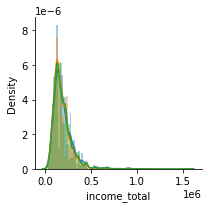

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor("white")
g = sns.FacetGrid(df, hue="credit")
g = g.map(sns.distplot, "income_total")

In [ ]:
df.occyp_type.value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

# 전처리

In [ ]:
X_train, y = df.iloc[:,:-1], df.iloc[:,-1]

In [ ]:
test_copy = test.copy()

In [ ]:
# -값을 갖는 값 +로 교체
colname = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for col in colname:
  X_train[col] = abs(X_train[col])

for col in colname:
  test_copy[col] = abs(test_copy[col])

In [ ]:
def occyp_check(x):
  if type(x) == float:
    return 'Unknown'
  else:
    return x

In [ ]:
X_train.occyp_type = X_train.occyp_type.apply(occyp_check)
test_copy.occyp_type = test_copy.occyp_type.apply(occyp_check)

In [ ]:
features_index = X_train.dtypes[X_train.dtypes == 'object'].index

In [ ]:
unobject_index = X_train.dtypes[X_train.dtypes != 'object'].index

In [ ]:
#로그변환
train_log = np.log1p(X_train[unobject_index])
test_log = np.log1p(test_copy[unobject_index])

In [ ]:
# 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(X_train[features_index])

In [ ]:
X_ohe = pd.DataFrame(ohe.transform(X_train[features_index]), columns=ohe.get_feature_names()).reset_index(drop=True)

In [ ]:
test_ohe = pd.DataFrame(ohe.transform(test_copy[features_index]), columns=ohe.get_feature_names()).reset_index(drop=True)

In [ ]:
train = pd.concat([train_log.reset_index(drop=True), X_ohe], axis=1)

In [ ]:
test_new = pd.concat([test_log.reset_index(drop=True), test_ohe], axis=1)

# 모델링

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_cls = LogisticRegression(multi_class='multinomial')

In [ ]:
lr_cls.fit(train, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
result = lr_cls.predict_proba(test_new)

In [ ]:
sub.loc[:,:] = result

In [ ]:
sub.to_csv("/content/drive/MyDrive/머신러닝_실전예제/Dacon_신용카드연체판별/result/result1.csv")